In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# скачиваем кадры из целевого фильма про сортировочную машину
#https://drive.google.com/file/d/1wIR1fUJi2Xn8IC8F1DPTjxMuO0YDalH4/view?usp=sharing

!pip install -q gdown==4.7.3
!gdown --quiet 1wIR1fUJi2Xn8IC8F1DPTjxMuO0YDalH4 -O image_paths_films_2.zip
!unzip -q "image_paths_films_2.zip"


In [ ]:
# скачиваем второй "искусственный" датасет с просто апельсинами
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CQL5rwm3Xg5OTOzuPH8L")
project = rf.workspace("mikeylamb").project("oranges-93gop")
version = project.version(1)
dataset = version.download("yolov8")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Oranges-1 in yolov8:: 100%|██████████| 2268/2268 [00:00<00:00, 7855.13it/s]


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

import supervision as sv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# необходим для правильного отображения изображений в колабе
from google.colab.patches import cv2_imshow

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.3/78.2 GB disk)


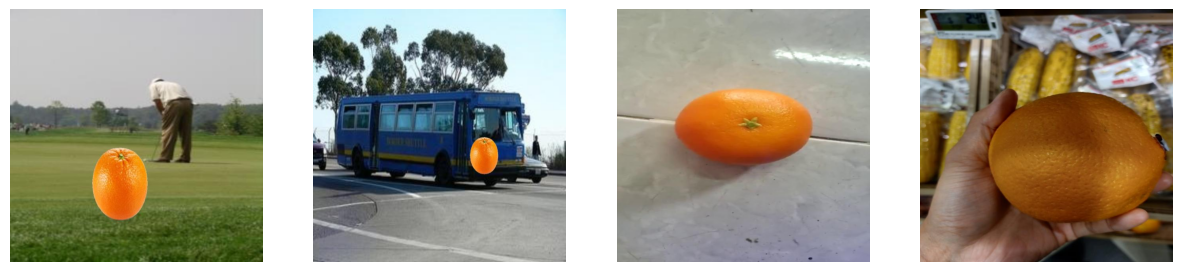

In [ ]:
# смотрим на изображения и аннотацию в датасете
# Пути к изображениям

image_paths = [
    '/content/Oranges-1/train/images/101_jpg.rf.33059b0ec7bc8f8a102a957d2264d505.jpg',
    '/content/Oranges-1/train/images/112_jpg.rf.062fbcec1d6d1239be42138a770ec9fe.jpg',
    '/content/Oranges-1/train/images/cam11_jpg.rf.b2c96184cde7368bfae1422ebb5b9d24.jpg',
    '/content/Oranges-1/train/images/orange-15-_jpg.rf.b9a7c246d9935ee09cde3ab4e46ad35d.jpg'
]


import yaml

def read_and_print_yaml(file_path):
    # Открываем файл и читаем его содержимое
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)

    # Выводим содержимое файла в нужном формате
    print(f"train: {data['train']}")
    print(f"val: {data['val']}")
    print(f"test: {data['test']}\n")
    print(f"nc: {data['nc']}")
    print(f"names: {data['names']}\n")
    print("roboflow:")
    for key, value in data['roboflow'].items():
        print(f"  {key}: {value}")





# Создаем subplot с тремя изображениями в одной строке
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(image_paths, start=1):
    plt.subplot(1, 4, i)  # 1 строка, 3 столбца, i-тое изображение
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Отключаем оси для чистого отображения

plt.show()


In [ ]:
read_and_print_yaml('/content/Oranges-1/data.yaml')

train: Oranges-1/train/images
val: Oranges-1/valid/images
test: ../test/images

nc: 4
names: ['2', 'banana', 'orange', 'oranges']

roboflow:
  license: CC BY 4.0
  project: oranges-93gop
  url: https://universe.roboflow.com/mikeylamb/oranges-93gop/dataset/1
  version: 1
  workspace: mikeylamb


In [ ]:
# меняем пути к изображениям на актуальные (необходимо для запуска обучения)
with open('/content/Oranges-1/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

# Modify the data
data['train'] = '../train/images'
data['val'] = '../valid/images'

# Save the modified data back to the YAML file
with open('/content/Oranges-1/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [ ]:
# проверяем
read_and_print_yaml('/content/Oranges-1/data.yaml')

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['2', 'banana', 'orange', 'oranges']

roboflow:
  license: CC BY 4.0
  project: oranges-93gop
  url: https://universe.roboflow.com/mikeylamb/oranges-93gop/dataset/1
  version: 1
  workspace: mikeylamb


In [ ]:
# проверяем аннотацию
for i, image_path in enumerate(image_paths):
    # Чтение разметки
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    with open(label_path) as f:
        annotation = f.read()

    # Получение списка строк
    annotation = annotation.split('\n')
    print(f'{i} : {image_path} : {annotation}')


0 : /content/Oranges-1/train/images/101_jpg.rf.33059b0ec7bc8f8a102a957d2264d505.jpg : ['2 0.434375 0.6890625 0.23046875 0.30859375']
1 : /content/Oranges-1/train/images/112_jpg.rf.062fbcec1d6d1239be42138a770ec9fe.jpg : ['2 0.6765625 0.578125 0.13671875 0.1640625']
2 : /content/Oranges-1/train/images/cam11_jpg.rf.b2c96184cde7368bfae1422ebb5b9d24.jpg : ['0 0.496875 0.46328125 0.56015625 0.3265625']
3 : /content/Oranges-1/train/images/orange-15-_jpg.rf.b9a7c246d9935ee09cde3ab4e46ad35d.jpg : ['2 0.61875 0.5890625 0.7140625 0.5234375']


In [ ]:
# скачиваем предобученную модель чуть больше слабейшей
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 125MB/s]


In [ ]:
# проверяем, как предсказывает предобученная модель без дообучения на нашем датасете
for img_in in image_paths:
  results = model.predict(img_in)
  result = results[0]
  detections = sv.Detections.from_ultralytics(result)

  bounding_box_annotator = sv.BoundingBoxAnnotator()
  label_annotator = sv.LabelAnnotator()

  labels = [
    model.model.names[class_id]
    for class_id
    in detections.class_id
  ]

  image = cv2.imread(img_in)

  annotated_image = bounding_box_annotator.annotate(
     scene=image, detections=detections)
  annotated_image = label_annotator.annotate(
     scene=annotated_image, detections=detections, labels=labels)

  sv.plot_image(annotated_image)
  for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    if class_id == 'orange' :
      cords = box.xyxy[0].tolist()
      cords = [round(x) for x in cords]
      conf = round(box.conf[0].item(), 2)
      print("Object type:", class_id)
      print("Coordinates:", cords)
      print("Probability:", conf)
      print("---")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# берем кадры из нашего целевого видео
image_paths_films = [
    '/content/image_paths_films_2/frame0.jpg',
    '/content/image_paths_films_2/frame180.jpg',
    '/content/image_paths_films_2/frame300.jpg',
    '/content/image_paths_films_2/frame420.jpg'
]

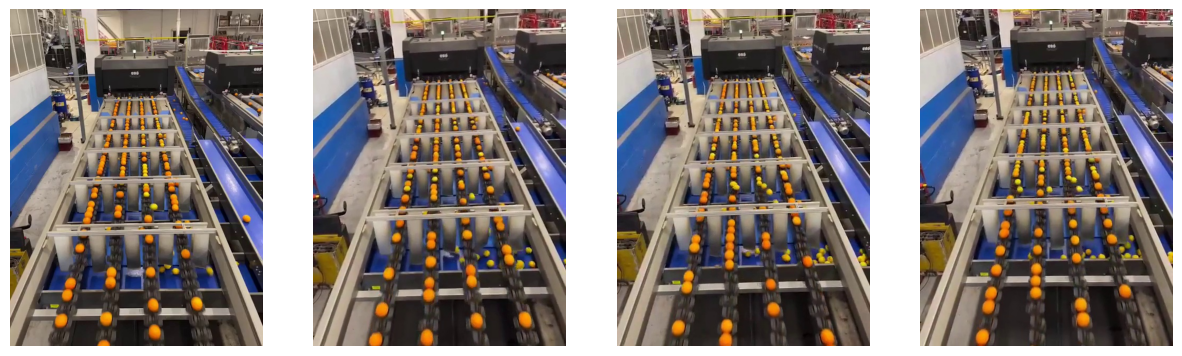

In [ ]:
# Создаем subplot с тремя изображениями в одной строке
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(image_paths_films, start=1):
    plt.subplot(1, 4, i)  # 1 строка, 3 столбца, i-тое изображение
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Отключаем оси для чистого отображения

plt.show()

In [ ]:
# проверяем, как предсказывает предобученная модель без дообучения на кадрах из нашего целевого видео
for img_in in image_paths_films:
  results = model.predict(img_in)
  result = results[0]
  detections = sv.Detections.from_ultralytics(result)

  bounding_box_annotator = sv.BoundingBoxAnnotator()
  label_annotator = sv.LabelAnnotator()

  labels = [
    model.model.names[class_id]
    for class_id
    in detections.class_id
  ]

  image = cv2.imread(img_in)

  annotated_image = bounding_box_annotator.annotate(
     scene=image, detections=detections)
  annotated_image = label_annotator.annotate(
     scene=annotated_image, detections=detections, labels=labels)

  sv.plot_image(annotated_image)
  for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    if class_id == 'orange' :
      cords = box.xyxy[0].tolist()
      cords = [round(x) for x in cords]
      conf = round(box.conf[0].item(), 2)
      print("Object type:", class_id)
      print("Coordinates:", cords)
      print("Probability:", conf)
      print("---")


Output hidden; open in https://colab.research.google.com to view.

<font color=green size=3>
Видим, что на реальных кадрах сортировочной машины предобученная модель опознала апельсин только один раз на одном кадре.
<br>
У меня было предположение, что этот датасет для этого целевого видео подходит достаточно хорошо, но оно не оправдалось.
<br>
Прямо из коробки она для этого целевого видео не работает.
<br>
Попробуем его улучшить через обучение на втором "искуственном" датасете.

</font>

In [ ]:
#!cp /content/data.yaml /content/Orange-5/data.yaml

In [ ]:
#!rm -r runs

In [ ]:
results_train = model.train(data='/content/Oranges-1/data.yaml', epochs=25)
#!cp runs /content/drive/MyDrive/data/itog_train_2/runs

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Oranges-1/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 87.5MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 258MB/s]


AMP: checks passed ✅


train: Scanning /content/Oranges-1/train/labels... 1017 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1017/1017 [00:01<00:00, 989.22it/s] 

train: New cache created: /content/Oranges-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Oranges-1/valid/labels... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<00:00, 539.66it/s]

val: New cache created: /content/Oranges-1/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      7.25G      1.307      1.973      1.716         21        640: 100%|██████████| 64/64 [00:41<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all         74        132      0.978       0.45      0.486      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       7.1G     0.8743      1.094      1.357         25        640: 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         74        132      0.936       0.45      0.473      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       7.3G     0.8551     0.9672      1.322         16        640: 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         74        132      0.972      0.458      0.498      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       7.2G     0.8321       0.83      1.296         18        640: 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         74        132      0.959      0.477      0.495      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      7.25G     0.8048     0.7806      1.272         16        640: 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         74        132      0.979      0.454      0.499      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       7.2G     0.7734     0.7071      1.252         20        640: 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         74        132      0.979      0.438       0.49      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      7.22G     0.7687     0.6564      1.233         29        640: 100%|██████████| 64/64 [00:34<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         74        132      0.951      0.469       0.49      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      7.23G     0.7429     0.6166      1.218         24        640: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         74        132      0.923      0.481       0.74      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      7.24G     0.7337     0.5991      1.212         24        640: 100%|██████████| 64/64 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         74        132      0.507      0.981      0.648       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      7.21G     0.7312     0.5901        1.2         36        640: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         74        132      0.393      0.485      0.585      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      7.21G     0.6873     0.5367      1.176         29        640: 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         74        132      0.968      0.445       0.51      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      7.22G     0.6837     0.5191      1.181         20        640: 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         74        132      0.442      0.481      0.523      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      7.22G     0.6814      0.538      1.158         21        640: 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         74        132      0.979      0.443      0.489      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      7.21G     0.6936     0.5114      1.165         43        640: 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         74        132      0.981      0.454      0.574      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      7.23G     0.6507     0.4616      1.138         28        640: 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         74        132      0.991      0.438      0.514       0.44


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      7.22G     0.5705     0.4397      1.107          8        640: 100%|██████████| 64/64 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         74        132      0.459       0.45      0.545      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      7.21G     0.5349     0.3883      1.094         11        640: 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         74        132      0.973      0.454      0.645      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      7.22G     0.5427     0.3745      1.081         10        640: 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         74        132       0.92      0.489      0.655      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      7.21G     0.5319     0.3555      1.076         20        640: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         74        132      0.511       0.97      0.566      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      7.21G      0.511     0.3478      1.049         10        640: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         74        132      0.958      0.461      0.734      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      7.32G     0.5066     0.3246      1.061          9        640: 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         74        132      0.963      0.472      0.537      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      7.22G     0.4904     0.3094      1.049         20        640: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         74        132      0.988      0.454      0.551      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      7.22G     0.4786     0.2995      1.037         10        640: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         74        132       0.47      0.458      0.529      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      7.22G     0.4641     0.2739      1.028          9        640: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         74        132      0.987      0.454      0.513      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      7.27G      0.459     0.2682      1.022         10        640: 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         74        132      0.469      0.454      0.486       0.42



25 epochs completed in 0.267 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


                   all         74        132      0.958      0.461      0.734      0.657
                orange         73        131      0.917      0.922       0.97      0.816
               oranges          1          1          1          0      0.497      0.497
Speed: 0.3ms preprocess, 10.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
validation_results = model.val(data='/content/Oranges-1/data.yaml')

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/Oranges-1/valid/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


                   all         74        132      0.958      0.461      0.734      0.657
                orange         73        131      0.917      0.922       0.97      0.817
               oranges          1          1          1          0      0.497      0.497
Speed: 0.4ms preprocess, 28.2ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train32


<font color=green size=3>
Если смотреть на метрики обучения по классу orange - у нас все прекрассно и с детекцией и с классификацией.
<br>
На проверочных данных датасета все метрики выше 90 процентов уже на 25 эпохах обучения.
<br>
Посмотрим как сработает обученная модель на кадрах из реалных роликов.
<br>

</font>

In [ ]:
cp runs /content/drive/MyDrive/data/itog_train_2/runs

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968